In [1]:
from scipy import optimize
import numpy as np
from matplotlib import pyplot
%matplotlib inline

from scipy import optimize
import numpy as np
from matplotlib import pyplot
import pandas as pd
from numpy import linalg as LA

from IPython.html import widgets
from IPython.display import display

from IPython.display import clear_output



/home/andres.python/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
f = pd.read_excel("PureFull.xls")
f.head()
data2 = pd.DataFrame(f)
data2 = data2.set_index('Name')
data2 = data2.ix[:, 1:12]
Etiquetas = data2.index.get_values()
Etiquetas

array(['METHANE', 'ETHANE', 'PROPANE', ..., 'TITANIUM', 'PHOSPHORUS',
       'PHOSPHORUS'], dtype=object)

In [3]:
# encoding: utf-8


import numpy as np
from numpy import linalg as LA


class Fugacidad():

    def __init__(self, eq, w, Tc, Pc, Tr, R, ep, ni, nT, nC, V, T, P, kij, lij, delta_1, k):
        self.eq = eq
        self.w = w
        self.Tc = Tc
        self.Pc = Pc
        self.Tr = Tr
        self.R = R
        self.ep = ep
        self.ni = ni
        self.nT = nT
        self.nC = nC
        self.V = V
        self.T = T
        self.P = P
        self.kij = kij
        self.lij = lij
        self.delta_1 = delta_1
        self.k = k
        
        if self.eq == "SRK":
            # Soave-Redlich-Kwong (SRK)
            self.s1, self.s2 = 1, 2
            self.m = 0.480 + 1.574 * self.w - 0.175 * self.w ** 2
            self.ac = 0.077796070 * self.R ** 2, self.Tc ** 2 / self.Pc
            self.bc = 0.086640 * self.R * self.Tc / self.Pc
        elif self.eq == "PR":
            # Peng-Robinson (PR)
            self.s1, self.s2 = 1 + 2 ** 0.5, 1 - (2 ** 0.5)
            self.m = 0.37464 + 1.54226 * self.w - 0.26992 * self.w ** 2
            self.ac = 0.45723553 * self.R ** 2 * self.Tc ** 2 / self.Pc
            self.bc = 0.077796070 * self.R * self.Tc / self.Pc            
           
            self.alfa = (1 + self.m * (1 - (self.T / self.Tc) ** 0.5)) ** 2
            self.dalfadT = - (self.m / self.T) * (self.T / self.Tc) ** 0.5 * (self.m * (- (self.T / self.Tc) ** 0.5 + 1) + 1)
            ter_1 = 0.5 * self.m ** 2 * (self.T / self.Tc) ** 1.0 / self.T ** 2
            ter_2 = 0.5 * self.m * (self.T / self.Tc) ** 0.5 * (self.m * (- (self.T / self.Tc) ** 0.5 + 1) + 1) / self.T ** 2
            
            self.d2alfaT2 = ter_1 + ter_2
            self.a_ii = self.ac * self.alfa
            self.b_ii = self.bc
            
            self.da_iidT = self.ac * self.dalfadT
            d2adT2_puros = self.ac * self.d2alfaT2

        elif self.eq == "RKPR":
            # (RKPR)
            
            self.delta_1m = sum(self.ni * self.delta_1)
            
            self.s1, self.s2 = self.delta_1m, (1-self.delta_1m)/(1+self.delta_1m)

            #datos C1 - C24
            self.ac = np.array([2.3213, 208.3471])
            self.bc = np.array([0.030088, 0.531299])
                        
            self.a_ii = self.ac * (3/(2+(self.T / self.Tc))) ** self.k
            self.b_ii = self.bc
            self.da_iidT = -self.k * self.a_ii / self.Tc/(2+(self.T / self.Tc))
            dadT2=-(self.k+1)*self.da_iidT/self.Tc/(2+(self.T / self.Tc))  
        else:
            print ("Che boludo... Modelo no valido, intentalo de nuevo !!! ")


    def parametros(self):           

        if self.nC > 1:
            self.aij = np.ones((len(self.ni), len(self.ni)))
            self.bij = np.ones((len(self.ni), len(self.ni)))
            self.daijdT = np.ones((len(self.ni), len(self.ni)))

            for j in range(self.nC):
                for i in range(self.nC):
                    self.aij[i, j] = (self.a_ii[i] * self.a_ii[j]) ** 0.5
                    self.bij[i, j] = (self.b_ii[i] + self.b_ii[j]) / 2
                    self.bij[i, j] = self.bij[i, j]
                    self.daijdT[i, j] = (self.da_iidT[i] * self.da_iidT[j]) ** 0.5

            for i in range(self.nC):
                for  j in range(self.nC):
                    if i == j:
                        self.aij[i, j] = self.a_ii[i] * (1 - self.kij[i, j])
                        self.daijdT[i, j] = self.da_iidT[i] * (1 - self.kij[i, j])
                    elif i != j:
                        self.aij[i, j] = self.aij[i, j] * (1 - self.kij[i, j])
                        self.daijdT[i, j] = self.daijdT[i, j] * (1 - self.kij[i, j])
                   
        if self.nC == 1:
            return self.a_ii, self.b_ii, self.da_iidT
        else:
            #print("inicial aij = ", self.aij)
            #print("bij = ", self.bij)
            #print("daijT = ", self.daijdT)
            return self.aij, self.bij, self.daijdT

    def parametro_D(self):
        if self.nC == 1:
            self.D = self.ni ** 2 * self.a_ii
            self.Di = 2 * self.ni * self.a_ii
        else:
            di = np.ones((len(self.ni), len(self.ni)))
            self.Di = np.ones((len(self.ni)))
            self.D = np.ones((len(self.ni)))
            for i in range(self.nC):
                for j in range(self.nC):
                    di[i, j] = self.ni[j] * self.aij[i, j]
                    self.Di[i] = 2 * np.sum(di[i, :])
            self.D = 0.5 * np.sum(self.ni * self.Di)

        return self.D
    
    def parametro_delta_1(self):
        
        if self.nC == 1:
            self.D1m = np.zeros((len(self.ni)-1))
            self.dD1i = np.ones((len(self.ni)))
            self.dD1ij = np.ones((len(self.ni), len(self.ni)))
            
            for i in range(self.nC):
                self.D1m = self.D1m + self.ni[i] * self.delta_1[i]
            
            self.D1m = self.D1m / self.nT
            
            #for i in range(self.nC):
            #    self.dD1i[i] = (self.delta_1[i] - self.D1m) / self.nT
            #    for j in range(self.nC):
            #        self.dD1ij[i,j] = (2.0 * self.D1m - self.delta_1[i] - self.delta_1[j]) / self.nT ** 2
        else:
            self.D1m = np.zeros((len(self.ni)-1))
            self.dD1i = np.ones((len(self.ni)))
            self.dD1ij = np.ones((len(self.ni), len(self.ni)))
            
            for i in range(self.nC):
                self.D1m = self.D1m + self.ni[i] * self.delta_1[i]
            
            self.D1m = self.D1m / self.nT
            
            for i in range(self.nC):
                self.dD1i[i] = (self.delta_1[i] - self.D1m) / self.nT
                for j in range(self.nC):
                    self.dD1ij[i,j] = (2.0 * self.D1m - self.delta_1[i] - self.delta_1[j]) / self.nT ** 2
                    
        return self.D1m, self.dD1i, self.dD1ij
                    
    def parametro_B(self):
        if self.nC == 1:
            self.B = self.ni * self.b_ii
        else:
            self.aux = np.zeros((len(self.ni)))
            for i in range(self.nC):
                for j in range(self.nC):
                    self.aux[i] = self.aux[i] + self.ni[j] * self.bij[i, j]

            self.B = np.sum(self.ni * self.b_ii)
            #print("B = ", self.B)

        return self.B

    def presion(self):
        '''
        Con el metodo presion(), se calcula la Presión P(T, V, N) del sistema
        para una temperatura T, cantidad de moles N y un volumen V
        R = Constante universal de los gases
        nT = Número total de moles en el sistema
        Pcal = Peos = Presión calculada con la ecuación de estado
        Arv = Primera derivada parcial de la energía de Helmholz con respecto al
        volumen V, a T y N constantes
        '''
        self.gv = self.R * self.B / (self.V * (self.V - self.B))
        self.fv = - 1 / ((self.V + self.s1 * self.B) * (self.V + self.s2 * self.B))
        self.ArV = -self.nT * self.gv * self.T - self.D * self.fv
        self.Pcal = self.nT * self.R * self.T / self.V - self.ArV   

        return self.Pcal

    def dP_dV(self):
        self.dPdV = -self.ArV2 - self.R * self.T * self.nT / self.V ** 2
        return self.dPdV

    def Z_factor(self):
        self.Z = (self.P * self.V) / (self.nT * self.R * self.T)
        return self.Z

    def P_ideal(self):
        self.Pxi = (self.ni * self.P) / self.nT
        return self.Pxi

    def dF_dV(self):
        '''
        Primera derivada de F con respecto al volumen Ecu. (68)
        '''
        self.gv = self.R * self.B / (self.V * (self.V - self.B))
        self.fv = - 1 / ((self.V + self.s1 * self.B) * (self.V + self.s2 * self.B))
        self.ArV = -self.nT * self.gv * self.T - self.D * self.fv
        return self.ArV

    def dF_dVV(self):
        '''
        Segunda derivada de F con respecto al volumen Ecu. (74)
        '''
        self.gv2 = self.R * (1 / self.V ** 2 - 1 / (self.V - self.B) ** 2)
        self.fv2 = (- 1 / (self.V + self.s1 * self.B) ** 2 + 1 / (self.V + self.s2 * self.B) ** 2) / self.B / (self.s1 - self.s2)
        self.ArV2 = - self.nT * self.gv2 * self.T - self.D * self.fv2
        return self.ArV2

    def volumen_1(self):
        '''
        Calculo del volumen V(T,P,n) del fluido a una temperatura T, presión P
        y número de moles totales nT especificados.
        Se utiliza el método de Newton con derivada de la función analitica.
        Pendiente cambiar por una función de Scipy.
        '''
        #self.P = P
        self.V = 1.05 * self.B  # SRK y PR
        #self.V = 1.10 * self.B  # RKPR
        
        lnP = np.log(self.P)
        #print ("P_esp = ", self.P)
        #print ("V_ini = ", self.V)
        Pite = self.presion()
        lnPcal = np.log(Pite)
        #h = self.P - Pite
        h = lnP - lnPcal
        errorEq = abs(h)
        #print ("ErrorP = ", errorEq)
        i = 0
        s = 1.0

        while errorEq > self.ep:
            self.parametro_D()
            self.parametro_B()
            self.dF_dV()
            self.dF_dVV()
            dPite = self.dP_dV()
            Pite = self.presion()
            lnPcal = np.log(Pite)
            #h = self.P - Pite
            h = lnP - lnPcal
            dh = -dPite
            #print self.nT
            self.V = self.V - s * h / dh
            errorEq = abs(h)
            #print "ErrorP = ", errorEq
            #print "V = ", self.V
            #print "Pite = ", Pite
            i += 1
            if i >= 900:
                pass
                #break
        #print ("FV = ", dPite)

        return self.V

    def funcion_energia_F(self):
        self.g = self.R * np.log(1 - self.B / self.V)
        self.bv = self.B / self.V
        self.f = np.log((self.V + self.s1 * self.B) / (self.V + self.s2 * self.B)) / self.B / (self.s1 - self.s2)
        self.Ar = -self.nT * self.g * self.T - self.D * self.f
        #print (("g = ", self.g))
        #print (("f: ", self.f))
        #print (("Ar: ", self.Ar))
        return self.g, self.f, self.Ar, self.bv
    
    def tomar_B(self):
        print ("tomando B =", self.B)
        return self.B + 10
    
    def derivadas_delta_1(self):
        #DERIVATIVES OF f WITH RESPECT TO DELTA1
        auxD2 = (1 + 2 / (1 + self.s1) ** 2)
        print("B delta1 = ", self.B)
        
        como_1 = (1 / (self.V + self.s1 * self.B) + 2 / (self.V + self.s2 * self.B) / (1 + self.s1) ** 2)
        como_2 = self.f * auxD2
        self.fD1 = como_1 - como_2
        #self.fD1 = (1 / (self.V + self.s1 * self.B) + 2 / (self.V + self.s2 * self.B) / (1 + self.s1) ** 2) - self.f * auxD2
        self.fD1 = self.fD1/(self.s1 - self.s2)
        
        return self.fD1

    def primeras_derivadas1(self):
        #print ("# compo = .......", self.nC)

        if self.nC == 1:
            AUX = self.R * self.T / (self.V - self.B)
            self.fB = -(self.f + self.V * self.fv) / self.B
            self.FFB = self.nT * AUX - self.D * self.fB
            self.Di = 2 * self.nT * self.ac * self.alfa
            self.Bi = self.bc
            
            if self.eq != "RKPR":
                self.Arn = -self.g * self.T + self.FFB * self.Bi - self.f * self.Di
            else:
                self.Arn = -self.g * self.T + self.FFB * self.Bi - self.f * self.Di - self.D * self.fD1 * self.dD1i
        else:
            # Derivando la ecuación (64) se obtiene la ecuación eq (106)
            self.Bi = np.ones((len(self.ni)))
            for i in range(self.nC):
                self.Bi[i] = (2 * self.aux[i] - self.B) / self.nT

            AUX = self.R * self.T / (self.V - self.B)
            self.fB = -(self.f + self.V * self.fv) / self.B
            self.FFB = self.nT * AUX - self.D * self.fB
            
            if self.eq != "RKPR":
                self.Arn = -self.g * self.T + self.FFB * self.Bi - self.f * self.Di
            else:
                #DERIVATIVES OF f WITH RESPECT TO DELTA1
                auxD2 = (1 + 2 / (1 + self.s1) ** 2)
                print("B delta1 = ", self.B)
                co_1 = (1 / (self.V + self.s1 * self.B) + 2 / (self.V + self.s2 * self.B) / (1 + self.s1) ** 2)
                co_2 = self.f * auxD2
                self.fD1 = co_1 - co_2
                #self.fD1 = (1 / (self.V + self.s1 * self.B) + 2 / (self.V + self.s2 * self.B) / (1 + self.s1) ** 2) - self.f * auxD2
                self.fD1 = self.fD1/(self.s1 - self.s2)
                self.Arn = -self.g * self.T + self.FFB * self.Bi - self.f * self.Di - self.D * self.fD1 * self.dD1i

        #print("Bi = ", self.Bi)
        #print ("Di = ", self.Di)
        #print ("fB = ", self.fB)
        #print ("FFB = ", self.FFB)
        #print ("Arn cal = ", self.Arn)

        return self.Arn, self.Arn, self.Arn

    

    def coeficientes_fugacidad(self):
        self.Z = self.Z_factor()
        self.lnOi = self.Arn / (self.R * self.T) - np.log(self.Z)
        self.Oi = np.exp(self.lnOi)

        #print("lnOi = ", self.lnOi)
        #print("Oi = ", self.Oi)

        return self.Oi

    def fugacidad(self):
        self.Z = self.Z_factor()
        self.Pxi = self.P_ideal()
        self.lnFi = self.Arn / (self.R * self.T) - np.log(self.Z) + np.log(self.Pxi)
        self.Fi = np.exp(self.lnFi)
        self.PHILOG = self.Arn / (self.R * self.T) - np.log(self.Z)
        self.PHILOG_i = self.Arn - np.log(self.Z)
        self.FUGLOG = self.Arn / (self.R * self.T) + np.log(self.ni) + np.log((self.nT * self.R * self.T) / self.V)

        #print ("Z = ", self.Z)
        #print ("Arn = ", self.Arn)
        #print ("Arn/RT = ", self.Arn / (self.R * self.T))
        #print ("ln(ni) = ", np.log(self.ni))
        #print ("ln (nT*R*T/V) = ", np.log((self.nT * self.R * self.T) / self.V))
        #print ("lnFi = ", self.lnFi)
        #print ("Fi = ", self.Fi)
        #print ("PHILOG = ", self.PHILOG)
        #print ("PHILOG_i = ", self.PHILOG_i)
        #print ("FUGLOG = ", self.FUGLOG)

        return self.Fi

    def exp_sol(self):
        '''
        Este método calcula el factor de corrección de la fugacidad del
        componente fluido para determinar la fugacidad del mismo componente
        en estado sólido.
        Fugacidad del sólido puro
        fi_s(T, P) = fi_l(T, P) * EXP(T, P)
        '''
        Tfus = 323.75
        # Temperatura de fusion de n-tetracosane
        # Unidad de Ti_f en Kelvin
        par_sol = np.array([[-176120.0, 8196.20, -55.911, 0.19357, -0.0002235],
                            [-1.66e6, 8.31e3, 0.0, 0.0, 0.0]])
        par_liq = np.array([[423160.0, 1091.9, 0.0, 0.0, 0.0],
                            [7.01e5, 1.47e3, 0.0, 0.0, 0.0]])
        #print ("par_sol", par_sol)
        #print ("par_liq", par_liq)
        # Las unidades de Cp están en J/Kmol.K
        Cp_solido = par_sol[:, 0] + par_sol[:, 1] * T + par_sol[:, 2] * T ** 2 + par_sol[:, 3] * T ** 3 + par_sol[:, 4] * T ** 4
        #print ("Cp_solido", Cp_solido)
        Cp_liquido= par_liq[:, 0] + par_liq[:, 1] * T + par_liq[:, 2] * T ** 2 + par_liq[:, 3] * T ** 3 + par_liq[:, 4] * T ** 4
        #print ("Cp_liquido", Cp_liquido)
        DeltaCp = (Cp_solido - Cp_liquido) * (1.0 / 1000)
        print ("Delta Cp", DeltaCp)

        #Unidades de Delta H de fusión en Kcal/mol
        DeltaH_f = np.array([13.12, 21.23]) * (1000 / 1.0) * (4.18 / 1.0)
        #print ("Delta H de fusion", DeltaH_f)
        T_f = np.array([323.75, 349.05])
        #print ("Temperaturas de fusion = ", T_f)

        Rp = 8.314
        A = (DeltaH_f / (Rp * Tfus)) * (1 - (Tfus / T))
        B = (DeltaCp / Rp) * (1 - (Tfus / T))
        C = (DeltaCp / Rp) * np.log(Tfus / T)
        self.EXP = np.exp(A - B - C)

        print ("A = ", A)
        print ("B = ", B)
        print ("C = ", C)
        print ("EXP = ", self.EXP)

        return self.EXP
    
    def exp_sol_1(self):
        '''
        Este método calcula el factor de corrección de la fugacidad del
        componente fluido para determinar la fugacidad del mismo componente
        en estado sólido.
        Fugacidad del sólido puro
        fi_s(T, P) = fi_l(T, P) * EXP(T, P)
        '''
        Tpt = 323.75
        Ppt = 1.38507E-8
        R = 8.314472
        AH = 54894000
        Av = -0.0376300841 #m3/kmol
        
        a = ((AH / (R * Tpt)) * (1 - (Tpt / self.T))) / 1000
        b = ((Av / (R * self.T)) * (self.P - Ppt)) / 100
        self.EXP_1 = a + b
        
        return self.EXP_1
    
    def exp_sol_3(self):
        '''
        Este método calcula el factor de corrección de la fugacidad del
        componente fluido para determinar la fugacidad del mismo componente
        en estado sólido.
        Fugacidad del sólido puro
        fi_s(T, P) = fi_l(T, P) * EXP(T, P)
        '''
        # [=] K
        # [=] bar
        # [m3 / Kmol]
        # Constante R [=] 0.08314472 bar.l/(mol.K)
        
        Tpt = 323.75
        Ppt = 3.2015002E-8
        Avsl = -0.0565500835
        
        c1 = -14213.5004
        c2 = 605153.4382
        c3 = -591592.556
        
        R = 0.08314472
        
        A1 = c1 * (1 - Tpt / self.T)
        A2 = c2 * (-1 + Tpt / self.T + np.log(self.T / Tpt))
        A3 = c3 * (-1 + self.T / (2 * Tpt) + Tpt / (2 * self.T)) + (Tpt / self.T) * (self.P - Ppt)
        
        FE = (Avsl / (R * self.T)) * (A1 + A2 + A3)
        self.EXP_3 = np.exp(FE)
        #EFE
        
        return self.EXP_3
        

    def fluido(self):
        #self.P = P
        #ab = self.parametros(self.ni, self.nT, self.nC, self.V, self.T)
        ab = self.parametros()        
        #print (("aij = ", ab[0]))
        #print (("bij = ", ab[1]))
        #print ("................................................................")
        D = self.parametro_D()
        B = self.parametro_B()
        #print (("D = ", D))
        #print (("B = ", B))
        #print ("................................................................")
        Vol_1 = self.volumen_1()
        #print (("Volumen_1 = ", Vol_1))
        #print (("Densidad =", 1 / Vol_1))
        #print ("................................................................")
        F = self.funcion_energia_F()
        #print (("g = ", F[0]))
        #print (("f = ", F[1]))
        #print (("F = ", F[2]))
        #print (("bv = ", F[3]))
        #print ("................................................................")
        dF = self.primeras_derivadas1()
        #print (("dFdni = ", dF[0]))
        #print (("dFdT = ", dF[1]))
        #print (("dFdV = ", dF[2]))
        #print ("................................................................")
        Z = self.Z_factor()
        #print ("Z =", Z)
        Zcal = (self.P * Vol_1) / (self.nT * self.R * self.T)
        #print ("Zcal =", Zcal)
        #print ("................................................................")
        Pq = self.presion()
        #print (("Pcal =", Pq))
        #print ("................................................................")
        self.Fug = self.fugacidad()
        #print (("Fug = ", self.Fug[0]))

        self.CoeFug = self.coeficientes_fugacidad()

        #self.CoeFug = self.Fug / (self.ni * self.P)

        #print (("Fug = ", self.Fug))
        #print (("CoeFug = ", self.CoeFug))
        #print (("lnCoeFug = ", np.log(self.Fug / (self.ni * self.P))))
        #print ("................................................................")

        return self.Fug

    def solido(self):
        if self.nC == 1:
            Fug = self.fluido()
            #EXP = self.exp_sol()
            #EXP = self.exp_sol_1()
            EXP = self.exp_sol_3()
            
            #print("Exponente = ", EXP)
            FugS = Fug[0] * EXP
            #print ("FugS = ", FugS)
        else:
            print ("Aún no se qué hacer para una mezcla de sólidos !!!")
            FugS = 1

        return FugS


    def wilson(self, Pc, Tc, w, T):
        # Ecuación wilson
        lnKi = np.log(Pc / self.P) + 5.373 * (1 + w) * (1 - Tc / self.T)
        self.Ki = np.exp(lnKi)
        return self.Ki

    def beta(self, zi):
        self.zi = zi
        self.Ki = self.wilson(Pc, Tc, w, T)
        Bmin = np.divide((self.Ki * self.zi - 1), (self.Ki - 1))
        #print (("Bmin_inter = ", Bmin))
        Bmax = np.divide((1 - self.zi), (1 - self.Ki))
        #print (("Bmax_inter = ", Bmax))
        self.Bini = (np.max(Bmin) + np.min(Bmax)) / 2
        return self.Bini

    def rice(self, zi, Ki, Bini):
        self.zi = zi
        self.Bini = Bini
        self.Ki = Ki
        self.fg = np.sum(self.zi * (self.Ki - 1) / (1 - self.Bini + self.Bini * self.Ki))
        self.dfg = - np.sum(self.zi * (self.Ki - 1) ** 2 / (1 - self.Bini + self.Bini * self.Ki) ** 2)
        #print g, dg
        return self.fg, self.dfg

    def flash_ideal(self):
        self.Bini = self.beta(zi)
        self.Ki = self.wilson(self.Pc, self.Tc, self.w, self.T)
        print ("Ki_(P, T) = ", self.Ki)
        Eg = self.rice(zi, self.Ki, self.Bini)
        errorEq = abs(Eg[0])
        i, s = 0, 1

        while errorEq > ep:
            Eg = self.rice(zi, self.Ki, self.Bini)
            self.Bini = self.Bini - s * Eg[0] / Eg[1]
            errorEq = abs(Eg[0])
            i += 1
            if i >= 50:
                break

        xy = self.composicion_xy(zi, self.Ki, self.Bini)
        print ("Metano, Butano, Hexano")
        print ("-------------Composición de fase líquida------------------------")
        print ("xi = ", xy[0])
        print ("Sxi = ", np.sum(xy[0]))
        print ("-------------Composición de fase vapor------------------------")
        print ("yi = ", xy[1])
        print ("Syi = ", np.sum(xy[1]))

        return Eg[0], Eg[1], self.Bini

    def flash_PT(self):
        flashID = self.flash_ideal()
        print ("flash (P, T, zi)")
        print ("g, dg, B = ", flashID)
        print ("---------------------------------------------------------------")

        self.Bini = flashID[2]
        print ("Beta_r ini = ", self.Bini)
        moles = self.composicion_xy(zi, self.Ki, self.Bini)

        self.xi, self.yi = moles[0], moles[1]
        nil, niv = moles[2], moles[3]

        fi_F = self.fugac()

        #print "nil = ", nil, np.sum(nil)
        #print "Snil = ", np.sum(nil)
        #print "niv", niv, np.sum(niv)
        #print "Sniv = ", np.sum(niv)

        #nF = 2
        #CoeFugi = np.ones((nF, nC))

        #for i in range(nF):
        #    if i == 1:
        #        self.ni = nil
        #        self.nT = np.sum(self.ni)
        #    elif i == 2:
        #        self.ni = niv
        #        self.nT = np.sum(self.ni)

        #    Flug_i = self.fluido(self.P)
        #    CoeFugi[i, :] = Flug_i[1]

        #print CoeFugi
        #self.Ki = CoeFugi[0, :] / CoeFugi[1, :]

        self.Ki = fi_F[0] / fi_F[1]

        L = 1.0

        self.Ki = self.Ki * L

        Ki_1 = self.Ki
        print ("Ki_(P, T, ni) primera = ", self.Ki)

        print ("----------------------------------------------------------------")

        #self.Ki = np.array([1.729, 0.832, 0.640])

        #self.Ki = self.wilson(self.Pc, self.Tc, self.w, self.T)
        #print "Ki_(P, T) = ", self.Ki

        while 1:
            i, s = 0, 0.1

            while 1:
                Eg = self.rice(zi, self.Ki, self.Bini)
                print (Eg)
                self.Bini = self.Bini - s * Eg[0] / Eg[1]
                print (self.Bini)
                errorEq = abs(Eg[0])
                i += 1
                #print i

                #if self. Bini < 0 or self.Bini > 1:
                    #break
                #    self.Bini = 0.5
                if i >= 50:
                    pass
                    #break
                if errorEq < 1e-5:
                    break

            print ("Resultado Real = ", Eg)
            print (" Beta r = ", self.Bini)

            moles = self.composicion_xy(zi, self.Ki, self.Bini)
            self.xi, self.yi = moles[0], moles[1]

            #xy = self.composicion_xy(zi, self.Ki, self.Bini)

            print ("C1 -i-C4 n-C4")
            print ("-----------Composición de fase líquida----------------------")
            print ("xi = ", moles[0])
            print ("Sxi = ", np.sum(moles[0]))
            print ("-----------Composición de fase vapor------------------------")
            print ("yi = ", moles[1])
            print ("Syi = ", np.sum(moles[1]))

            fi_F = self.fugac()

            self.Ki = fi_F[0] / fi_F[1]
            Ki_2 = self.Ki
            dKi = abs(Ki_1 - Ki_2)
            Ki_1 = Ki_2
            print ("Ki_(P, T, ni) = ", self.Ki)

            fun_Ki = np.sum(dKi)
            print ("fun_Ki = ", fun_Ki)

            if fun_Ki < 1e-5:
                break

        return flashID

    def fugac(self):
        '''
        Esta función que se llama fugacidad, calcula los coeficientes de fugacidad
        con una ecuación de estado para mezclas multicomponente
        T = temperatura en Kelvin
        Y = fracción molar del componente i en la fase de vapor
        X = fracción molar del componente i en la fase líquida
        '''
        self.T
        self.P
        #----------------------------------------------------------------------
        self.Fw = 0.48 + (1.574 * self.w) - (0.176 * self.w ** 2)
        a = ((0.42748 * (self.R * self.Tc) ** 2) / self.Pc) * ((1 + self.Fw * (1 - (self.Tr ** 0.5))) ** 2)
        b = (0.08664 * self.R * self.Tc) / self.Pc
        #----------------------------------------------------------------------
        #print Fw, "Parametro a:", a, b

        #Yf = np.array([Y4,Y5,Y6])
        Yf = self.yi
        Xf = self.xi
        #print Yf, Xf
        #----------------------- Vapor -----------------------------------------
        amv = np.sum(Yf * a ** 0.5) ** 2
        aml = np.sum(Xf * a ** 0.5) ** 2
        #-------------------------------
        #print "amv = ", amv
        #print "aml = ", aml

        bmv = np.sum(Yf * b)
        bml = np.sum(Xf * b)
        #print "bmv = ", bmv
        #print "bml = ", bml

        Av = (amv * self.P) / ((self.R * self.T) ** 2)
        Bv = (bmv * self.P) / (self.R * self.T)
        #-------------------- Liquido -------------------
        Al = (aml * self.P) / ((self.R * self.T) ** 2)
        Bl = (bml * self.P) / (self.R * self.T)
        #print "Av", Av
        #print "Bv", Bv
        #print "Al", Al
        #print "Av", Bl

        Zfv = [1, -1, (Av - Bv - Bv ** 2), (- Av * Bv)]
        ZfvR = np.roots(Zfv)
        Zv = np.max(ZfvR)
        #print "Zv = ", Zv

        Zfl = [1, -1, (Al - Bl - Bl ** 2), (- Al * Bl)]
        ZflR = np.roots(Zfl)
        Zl = np.min(ZflR)
        #print "Zl = ", Zl
        #----------------------------------------------------------------------
        lnfiv = (b / bmv) * (Zv - 1) - np.log(Zv - Bv) + (Av / Bv)  * ((b / bmv) - (2 * ((a / amv) ** 0.5))) * np.log((Zv + Bv) / Zv)
        self.fiv = np.exp(lnfiv)
        print ("fiv = ", self.fiv)
        lnfil = (b / bml) * (Zl - 1) - np.log(Zl - Bl) + (Al / Bl)  * ((b / bml) - (2 * ((a / aml) ** 0.5))) * np.log((Zl + Bl) / Zl)
        self.fil = np.exp(lnfil)
        print ("fil = ", self.fil)

        return self.fil, self.fiv


    def composicion_xy(self, zi, Ki, Bini):
        self.zi = zi
        self.Ki = Ki
        self.Bini = Bini
        self.xi = zi / (1 - self.Bini + self.Bini * self.Ki)
        self.yi = (zi * self.Ki) / (1 - self.Bini + self.Bini * self.Ki)
        self.li = (zi * (1 - self.Bini)) / (1 - self.Bini + self.Bini * self.Ki)
        self.vi = (zi * self.Bini * self.Ki) / (1 - self.Bini + self.Bini * self.Ki)

        return self.xi, self.yi, self.li, self.vi

In [5]:

def calculaFugacidad(x, Pe, nCf, eq, TcmDato, PcmDato, wmDAto):
    #---------------------------------------------------------------------------
    #print ("-"*100)
    #itera += 
    #print (itera)
    # Temperatura en K
    # Presión en bar
    # Constante R [=] 0.08314472 bar.l/(mol.K)
    
    # selección de la Ecuación de Estado,
    # eq = 1, (SRK)
    # eq = 2, (PR)
    
    # ep = Criterio de convergencia del método def volumen_1(self, P)
    
    T = x # 335.42 # x # 366.78 # 356.429 # 335.42 # 348.89 #327.0
    #print("Temperatura = ", T)
    P = Pe # 2575.0 # 2064.7 # 1524.4 #1164.2 # 865.0 
    # 560.3 # x #1054.6 #1560.3 # 2064.7 # 1524.4 # 560.3 # 1164.2 #865.0
    R = 0.08314472
    #eq = "PR"
    ep = 1e-5#1e-6
    #---------------------------------------------------------------------------
    # metano - C24
    #Tcm = np.array([190.564, 804.0])
    #Pcm = np.array([45.99, 9.672])
    #wm = np.array([0.0115478, 1.07102])
    
    Tcm = TcmDato
    Pcm = PcmDato
    wcm = wcmDato
    
    
    nC = nCf
    
    if nC == 1:
        #print ("...............................................................")
        ni = np.array([1.0])
        #print ("Número de moles = ", ni)
        # C24
        kij = 0.0
        lij = 0.0
        
        # Metano - Etano
        delta_1 = np.array([0.85])        
        k = np.array([1.50758])
        #----------------------------------------------------------------------
        #C24
        Tc = Tcm[1]
        Pc = Pcm[1]
        w = wm[1]
        print ("Temperatura Critica = ", Tc, "K")
        print ("Presión Critica = ", Pc, "bar")
        print ("Factor Acentrico = ", w)       
        print ("...............................................................")
    elif nC == 2:
        #print ("...............................................................")
        # metano - C24
        ni = np.array([1 - 0.901, 0.901])
        #ni = np.array([1 - 0.104, 0.104])
        #print ("Número de moles = ", ni)

        kij = np.array([[0.000000, 0.083860],
                        [0.083860, 0.000000]])
        
        kij = np.array([[0.000000, 0.059600],
                        [0.059600, 0.000000]])

        lij = 0.0132
        # Metano - C24
        delta_1 = np.array([0.85, 2.40])        
        k = np.array([1.50758, 4.90224])
        
        # metano sigma1 = 0.9253, sigma = 0.85, k = 1.49345, k = 1.50758
        # C24 sigma = 2.40 k = 4.90224

        Tc = Tcm
        Pc = Pcm
        w = wm
        print ("Temperatura Critica = ", Tc, "K")
        print ("Presión Critica = ", Pc, "bar")
        print ("Factor Acentrico = ", w)
        #print ("...............................................................")

    #---------------------------------------------------------------------------
    # Tempertura reducidad
    Tr = T / Tc
    # C24 puro
    V = 0.141604834257319
    nT = np.sum(ni)

    #print ("...................................................................")
    fugacidad = Fugacidad(eq, w, Tc, Pc, Tr, R, ep, ni, nT, nC, V, T, P, kij, lij, delta_1, k)
    
    #print(fugacidad.parametro_delta_1())
    #print(fugacidad.ac)
    #print(fugacidad.bc)
    #print(fugacidad.parametros())
    #print("D = ",fugacidad.parametro_D())
    #print("B = ",fugacidad.parametro_B())
    #print("tomar B = ", fugacidad.tomar_B())
    #print("fD1 = ", fugacidad.derivadas_delta_1())
        
    if nC == 1:
        SOL = fugacidad.solido()
        #print ("...................................................................")
        #print ("FUG_SOLID = ", SOL)
        #print ("lnFUG_SOLID = ", np.log(SOL))
        #print ("...................................................................")
        
        return SOL
    else:
        flu_1 = fugacidad.fluido()
        return flu_1    

    




In [6]:
Componentes_1 = widgets.SelectMultiple(
    description="Componente 1",
    options=list(Etiquetas))

Componentes_2 = widgets.SelectMultiple(
    description="Componente 2",
    options=list(Etiquetas))

display(Componentes_1)
display(Componentes_2)


In [7]:
button = widgets.Button(description="Cargar Datos")

def cargarDatos(b):
    clear_output()
    print("Compnenete 1: ", Componentes_1.value)
    Nombre = Componentes_1.value
    Propiedades = data2.loc[Nombre]
    Factor_Acentrico_1 = Propiedades[0]
    Temperatura_Critica_1 = Propiedades[1]
    Presion_Critica_1 = Propiedades[2]
    Z_Critico_1 = Propiedades[3]

    #print(Propiedades)
    print ("Factor_Acentrico = ", Factor_Acentrico_1)
    print ("Temperatura_Critica = ", Temperatura_Critica_1, "K")
    print ("Presion_Critica = ", Presion_Critica_1, "bar")
    print ("Z_Critico = ", Z_Critico_1, "\n")
    
    
    print("Componente 2: ", Componentes_2.value)
    Nombre = Componentes_2.value
    Propiedades = data2.loc[Nombre]
    Factor_Acentrico_2 = Propiedades[0]
    Temperatura_Critica_2 = Propiedades[1]
    Presion_Critica_2 = Propiedades[2]
    Z_Critico_2 = Propiedades[3]

    #print(Propiedades)
    print ("Factor_Acentrico = ", Factor_Acentrico_2)
    print ("Temperatura_Critica = ", Temperatura_Critica_2, "K")
    print ("Presion_Critica = ", Presion_Critica_2, "bar")
    print ("Z_Critico = ", Z_Critico_2)
    
    global TcmDato, PcmDato, wcmDato
    
    eq = "PR"
    TcmDato = np.array([Temperatura_Critica_1, Temperatura_Critica_2])
    PcmDato = np.array([Presion_Critica_1, Presion_Critica_2])
    wcmDato = np.array([Factor_Acentrico_1, Factor_Acentrico_2])
    
    print(TcmDato, PcmDato, wcmDato)


button.on_click(cargarDatos)
display(button)


In [8]:
eq = "PR"
#TcmDato #= np.array([Temperatura_Critica_1, Temperatura_Critica_2])
#PcmDato #= np.array([Presion_Critica_1, Presion_Critica_2])
#wmDato #= np.array([Factor_Acentrico_1, Factor_Acentrico_2])

#TcmDato
calculaFugacidad(335.2, 1034.4, 2, eq, TcmDato, PcmDato, wcmDato)

NameError: name 'TcmDato' is not defined

In [9]:

t_exp = [323.65, 326.04, 326.43, 328.12, 329.45, 329.89, 333.43, 335.12, 340.19, 344.58, 346.65, 352.53, 362.45, 362.76, 371.82, 379.74]
temp = np.array(t_exp)

p_exp = [1, 101.0, 136.9, 183.8, 266.2, 266.8, 426.9, 480.3, 718.9, 912.5, 1010.6, 1277.8, 1778.0, 1825.1, 2323.4, 2736.1]
pres= np.array(p_exp)

pos = np.arange(len(pres))
Tcal = np.ones((len(pres)))
Tcal

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

In [10]:
def equilibrioSF(x, Pe, n1, n2):
    
    # fugacidad del sólido puro
    FugS = calculaFugacidad(x, Pe, n1, eq, TcmDato, PcmDato, wcmDato)
    print(eq, TcmDato, PcmDato, wcmDato)
    # fugacidad del fluido pesado en la mezcla fluida
    FugF = calculaFugacidad(x, Pe, n2, eq, TcmDato, PcmDato, wcmDato)
    
    # Función de igualdad de fugacidades del sólido y el fluido
    eqSF = np.abs(np.abs(np.log(FugS)) - np.abs(np.log(FugF[1])))
    print ("-"*100)
    print ("ln(Fugacidad Sólido) = ", np.log(FugS))
    print ("ln(Fugacidad Fluido) = ", np.log(FugF[1]))
    print ("ln(Fugacidad Sólido) - ln(Fugacidad Fluido) = ", eqSF)   
    
    return eqSF


from scipy.optimize import fsolve

guess = [346.5] # T [=] K
Pe = 136.9 # [=] bar


Tcal = fsolve(equilibrioSF,guess,args=(Pe, 1, 2), xtol=1e-4)
print(Tcal, "K")

NameError: name 'TcmDato' is not defined

In [11]:
button = widgets.Button(description="Sólido-Fluido")
#display(button)

from IPython.display import clear_output

nnCC_1 = 1
nnCC_2 = 2

def calcularSolidoFluido(b):
    clear_output()
    #Tcal = fsolve(equilibrioSF,guess,args=(Pe, 1, 2), xtol=1e-4)
    TemEquilibrioSF = fsolve(equilibrioSF,guess,args=(Pe, 1, 2), xtol=1e-4)
    print ("-"*100)
    print("Temperatura de Equilibrio SF = ", TemEquilibrioSF, "K")
    

button.on_click(calcularSolidoFluido)
display(button)


In [12]:
#Tcal = np.ones()

for x, Pes, i in zip(temp, pres, pos):
    print ("Temperatura inicial = ", x, "K", "Presión = ", Pes, "bar", "Datos experimental = ", i+1)
    
    guess = x # T [=] K
    Pe = Pes # [=] bar
    #Tcal[i] = fsolve(equilibrioSF,guess,args=(Pe, 1, 2), xtol=1e-4)
    Tcal[i] = fsolve(equilibrioSF,guess,args=(Pe, 1, 2), xtol=1e-4)
    

#ErrorT = np.abs(Tcal - temp)
#ErrorT
#print (Tcal, temp, ErrorT)
Tcal

Temperatura inicial =  323.65 K Presión =  1.0 bar Datos experimental =  1


NameError: name 'TcmDato' is not defined

In [71]:
Tcal

array([ 322.65861561,  324.91947001,  325.7351273 ,  326.80226377,
        328.6804546 ,  328.69414994,  332.3526484 ,  333.57247658,
        338.99640175,  343.33723297,  345.50684499,  351.28742834,
        361.49784458,  362.41457139,  371.63445361,  378.63493827])

In [40]:
Tres = np.array([ 322.65861561,  324.91946742,  325.73456905,  326.80151121,
        328.68045402,  328.69415114,  332.3526483 ,  333.57248076,
        338.99640222,  343.33723415,  345.50684642,  351.28742799,
        361.49784425,  362.4145721 ,  371.63445321,  378.63493779])

Tcal - temp 

array([-322.65, -325.04, -325.43, -327.12, -328.45, -328.89, -332.43,
       -334.12, -339.19, -343.58, -345.65, -351.53, -361.45, -361.76,
       -370.82, -378.74])

/home/andres.python/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


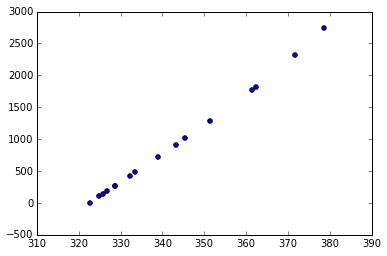

In [41]:
fig= pyplot.scatter(Tres,p_exp)


/home/andres.python/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


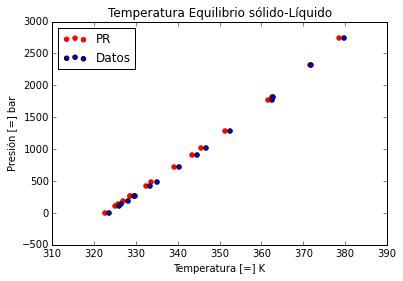

In [42]:
button = widgets.Button(description="Diagrama Sólido-Fluido")

def diagramaSolidoFluido(b):
    clear_output()
    pyplot.scatter(Tres,pres, color = 'red', label = 'PR')
    pyplot.scatter(temp,pres, label = 'Datos')
    pyplot.title('Temperatura Equilibrio sólido-Líquido')
    pyplot.legend(loc="upper left") 
    pyplot.xlabel('Temperatura [=] K')  
    pyplot.ylabel('Presión [=] bar')
    

button.on_click(diagramaSolidoFluido)
display(button)

In [31]:
t_exp = [323.65, 326.04, 326.43, 328.12, 329.45, 329.89, 333.43, 335.12, 340.19, 344.58, 346.65, 352.53, 362.45, 362.76, 371.82, 379.74]
temp = np.array(t_exp)

p_exp = [1, 101.0, 136.9, 183.8, 266.2, 266.8, 426.9, 480.3, 718.9, 912.5, 1010.6, 1277.8, 1778.0, 1825.1, 2323.4, 2736.1]
pres= np.array(p_exp)

pos = np.arange(len(pres))
num = np.ones(len(pres))

for x, P, i in zip(temp, pres, pos):
    print (x, P, i)
    num[i] = x
    
num

323.65 1.0 0
326.04 101.0 1
326.43 136.9 2
328.12 183.8 3
329.45 266.2 4
329.89 266.8 5
333.43 426.9 6
335.12 480.3 7
340.19 718.9 8
344.58 912.5 9
346.65 1010.6 10
352.53 1277.8 11
362.45 1778.0 12
362.76 1825.1 13
371.82 2323.4 14
379.74 2736.1 15


array([ 323.65,  326.04,  326.43,  328.12,  329.45,  329.89,  333.43,
        335.12,  340.19,  344.58,  346.65,  352.53,  362.45,  362.76,
        371.82,  379.74])

<h1> Equilibrio sólido-fluido binario<h1>

Ecuación ( 5.3) página V-3 

$$ f_{puro,2}^s(T,P) = \hat f_2 \left(T,P,y_2 \right) $$

$$ F = f_{puro,2}^s(T,P) - \hat f_2 \left(T,P,y_2 \right) $$

En este caso se tiene una ecuación con una incognita, que puede ser la $T$ cuando se especifica la $P$ y viceversa.

Se importa el método **fsolve** de la librería **scipy** como sigue:

**from scipy.optimize import fsolve**

el cual es utilizado para resolver la ecuación de igualdad de fugacidades del sólido y fluido calculada en la función **equilibrioSF**, que utiliza 


Ecuación (5.7) página V-6 

$$ f_{puro,2}^l(T,P) = \hat f_2 \left(T,y_2=1, v_{2, puro} \right) $$


<h2> Modelo para la fugacidad de un sólido puro <h2>

$$ f(T,P)_{puro,i}^s = f(T,P)_{puro,i}^l exp \left( \frac{\Delta v_i^{s-l}}{RT_{i,f}} \left( \lambda_1 + \lambda_2 + \lambda_3 \right)   \right)$$

$$ \lambda_1 = C_1\left( 1- \frac{T_{i,f}}{T}\right)$$

$$ \lambda_2 = C_2\left( -1- \frac{T_{i,f}}{T}  + ln \left(\frac{T}{T_{i,f}}\right) \right)$$

$$ \lambda_3 = C_3\left( -1 + \frac{T}{2T_{i,f}} + \frac{T_{i,f}}{2T} \right) + \frac{T_{i,f}}{T} \left(P-P_{i,f} \right)$$

$$ P = P_{i,f} + C_1\left( 1- \frac{T}{T_{i,f}}\right) + C_2\left(\frac{T}{T_{i,f}} -1 + \frac{T}{T_{i,f}}ln \left(\frac{T_{i,f}}{T}\right) \right) + C_3\left(\frac{T}{T_{i,f}} - \frac{T^2}{2T_{i,f}^2} - \frac{1}{2}  \right)$$

$$ C_1 = \frac{\Delta h_{i,f}}{\Delta v^{s-l}}$$

$$ C_2 = \frac{AT_{i,f}}{\Delta v^{s-l}}$$

$$ C_3 = \frac{BT_{i,f}^2}{\Delta v^{s-l}}$$

$$ K_i = \frac{\hat{\varphi}^L_i}{\hat{\varphi}^L_i} $$


In [28]:
d1 = 0.428363
d2 = 18.496215
d3 = 0.338426
d4 = 0.660000
d5 = 789.723105
d6 = 2.512393

A1 = -2.4407
A0 = 0.0017

B1 = 7.4513
B0 = 1.9681

C1 = 12.504
C0 = -2.7238

# metano
sigma1 = 0.9253
#sigma = 0.85
k = 1.49345


# fluidos no asociados
Zc_EPX = 0.29
Zc = 1.168 * Zc_EPX
Zc = 0.3384

#sigma1 = d1 + d2 * (d3 - Zc) ** d4 + d5 * (d3 - Zc) ** d6
#print("sigma1 = ", sigma1)

y = 1 + (2*(1 + sigma1)) ** (1/3) + (4/(1 + sigma1)) ** (1/3)

d1 =(1 + sigma1 ** 2) /(1 + sigma1)

#Zc = y / (3*y + d1 - 1)

#Zc
print("Zc = ", Zc)
print("d1 = ", d1)


phoa = (3*y**2 + 3*y*d1 + d1**2 + d1 - 1) / (3*y + d1 - 1)**2 
phoa

phob = 1 / (3*y + d1 - 1) 
phob

R, Tc, Pc, T = 0.08314472, 190.564, 45.99, 345 

ac = phoa * (R*Tc)**2 / Pc 
b = phob * (R*Tc) / Pc
a = ac * (3 / (2 + (T/Tc))) ** k

print("ac = ", ac)
print("b =", b)
print("a = ", a)


Zc =  0.3384
d1 =  0.9640991481846986
ac =  2.3271483904354966
b = 0.02997299114839177
a =  1.628274787231296


In [66]:
# metano
sigma1 = 0.9253
sigma = 0.85
k = 1.49345
k = 1.50758


# fluidos no asociados
Zc_EPX = 0.29
Zc = 1.168 * Zc_EPX

y = 1 + (2*(1 + sigma1)) ** (1/3) + (4/(1 + sigma1)) ** (1/3)

d1 =(1 + sigma1 ** 2) /(1 + sigma1)


print("Zc = ", Zc)
print("d1 = ", d1)


phoa = (3*y**2 + 3*y*d1 + d1**2 + d1 - 1) / (3*y + d1 - 1)**2 
phoa

phob = 1 / (3*y + d1 - 1) 
phob

R, Tc, Pc, T = 0.08314472, 190.564, 45.99, 345 

ac = phoa * (R*Tc)**2 / Pc 
b = phob * (R*Tc) / Pc
a = ac * (3 / (2 + (T/Tc))) ** k

print("ac = ", ac)
print("b =", b)
print("a = ", a)


Zc =  0.33871999999999997
d1 =  0.9640991481846986
ac =  2.3271483904354966
b = 0.02997299114839177
a =  1.6227823763588622


In [67]:
# C24
sigma = 2.40
k = 4.90224


# fluidos no asociados
Zc_EPX = 0.29
Zc = 1.168 * Zc_EPX

y = 1 + (2*(1 + sigma1)) ** (1/3) + (4/(1 + sigma1)) ** (1/3)

d1 =(1 + sigma1 ** 2) /(1 + sigma1)


print("Zc = ", Zc)
print("d1 = ", d1)


phoa = (3*y**2 + 3*y*d1 + d1**2 + d1 - 1) / (3*y + d1 - 1)**2 
phoa

phob = 1 / (3*y + d1 - 1) 
phob

R, Tc, Pc, T = 0.08314472, 804.0, 9.8, 345.0

ac = phoa * (R*Tc)**2 / Pc 
b = phob * (R*Tc) / Pc
a = ac * (3 / (2 + (T/Tc))) ** k

print("ac = ", ac)
print("b =", b)
print("a = ", a)

#datos C1 - C24
#ac = 2.3213 208.3471
#bc = 0.030088   0.531299

Zc =  0.33871999999999997
d1 =  0.9640991481846986
ac =  194.39799791981406
b = 0.5934479143239724
a =  547.1481496850862


In [2]:
from IPython.html import widgets
from ipywidgets import widgets
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from ipywidgets import *
import matplotlib.pyplot as plt
import ipywidgets as wdg

In [13]:
Componentes_1 = widgets.SelectMultiple(
    description="Componente 1",
    options=list(Etiquetas))

Componentes_2 = widgets.SelectMultiple(
    description="Componente 2",
    options=list(Etiquetas))

button = widgets.Button(description="Cargar Datos")

def cargarDatos(b):
    clear_output()
    print("Compnenete 1: ", Componentes_1.value)
    Nombre = Componentes_1.value
    Propiedades = data2.loc[Nombre]
    Factor_Acentrico_1 = Propiedades[0]
    Temperatura_Critica_1 = Propiedades[1]
    Presion_Critica_1 = Propiedades[2]
    Z_Critico_1 = Propiedades[3]

    #print(Propiedades)
    print ("Factor_Acentrico = ", Factor_Acentrico_1)
    print ("Temperatura_Critica = ", Temperatura_Critica_1, "K")
    print ("Presion_Critica = ", Presion_Critica_1, "bar")
    print ("Z_Critico = ", Z_Critico_1, "\n")
    
    
    print("Componente 2: ", Componentes_2.value)
    Nombre = Componentes_2.value
    Propiedades = data2.loc[Nombre]
    Factor_Acentrico_2 = Propiedades[0]
    Temperatura_Critica_2 = Propiedades[1]
    Presion_Critica_2 = Propiedades[2]
    Z_Critico_2 = Propiedades[3]

    #print(Propiedades)
    print ("Factor_Acentrico = ", Factor_Acentrico_2)
    print ("Temperatura_Critica = ", Temperatura_Critica_2, "K")
    print ("Presion_Critica = ", Presion_Critica_2, "bar")
    print ("Z_Critico = ", Z_Critico_2)
    
    global Tcm, Pcm, wm
    
    eq = "PR"
    Tcm = np.array([Temperatura_Critica_1, Temperatura_Critica_2])
    Pcm = np.array([Presion_Critica_1, Presion_Critica_2])
    wm = np.array([Factor_Acentrico_1, Factor_Acentrico_2])


button.on_click(cargarDatos)
#display(button)

page1 = widgets.VBox(children=[Componentes_1, Componentes_2, button], padding=4)


#VBox([VBox([Button(description='Press'), Dropdown(options=['a', 'b']), Button(description='Button')]), 
#      VBox([Button(), Checkbox(), IntText()]), 
#      VBox([Button(), IntSlider(), Button()])], background_color='#EEE')


ecuacionEstado = widgets.Dropdown(description='Fluido :', padding=4, options=['SRK', 'PR', 'RKPR'])
modeloSolido = widgets.Dropdown(description='Sólido :', padding=4, options=['Modelo I', 'Modelo II', 'Modelo III'])

button = widgets.Button(description="Cargar Modelos")

def cargarModelos(b):
    clear_output()
    print("Compnenete 1: ", Componentes_1.value)
    print("Componente 2: ", Componentes_2.value)
    print("Modelo Fluido : ", ecuacionEstado.value)
    print("Modelo Sólido : ", modeloSolido.value)

button.on_click(cargarModelos)

page2 = widgets.Box(children=[ecuacionEstado, modeloSolido, button], padding=4)



Kij = widgets.Text(description='$K_{ij}$ =', padding=4, value="0.0")
Lij = widgets.Text(description='$L_{ij}$ =', padding=4, value="0.0")

d1 = widgets.Text(description='$\delta_1$:', padding=4, value="0.0")
d2 = widgets.Text(description='$\delta_2$:', padding=4, value="0.0")

k1 = widgets.Text(description='$k_1$:', padding=4, value="0.0")
k2 = widgets.Text(description='$k_2$:', padding=4, value="0.0")

button = widgets.Button(description="Cargar Parametros")
titulo = widgets.HTML(
    #value="<H1>Hello<\H1> <b>World</b>"
    value="<C><H1>Parametros de interacción<H1>"
    
)

button = widgets.Button(description="Cargar Parametros")

def cargarParametros(b):
    clear_output()
    print("Compnenete 1: ", Componentes_1.value)
    print("Componente 2: ", Componentes_2.value)
    print("Modelo Fluido : ", ecuacionEstado.value)
    print("Modelo Sólido : ", modeloSolido.value)
    print("Kij =", Kij.value)
    print("Lij =", Lij.value)
    print("d1 = ", d1.value)
    print("d2 = ", d2.value)
    print("k1 = ", k1.value)
    print("k2 = ", k2.value)

button.on_click(cargarParametros)

page3 = widgets.Box(children=[titulo, Kij, Lij, d1, d2, k1, k2, button], padding=4)



button = widgets.Button(description="Sólido-Fluido")
#display(button)

from IPython.display import clear_output

nnCC_1 = 1
nnCC_2 = 2

def calcularSolidoFluido(b):
    clear_output()
    #Tcal = fsolve(equilibrioSF,guess,args=(Pe, 1, 2), xtol=1e-4)
    Tcal = fsolve(equilibrioSF,guess,args=(Pe, nnCC_1, nnCC_2), xtol=1e-4)
    print("Temperatura ESF = ", Tcal, "K")
    
   
    

button.on_click(calcularSolidoFluido)
#display(button)


page4 = widgets.Box(children=[button], padding=4)

button = widgets.Button(description="Diagrama Sólido-Fluido")

def DiagramaSolidoFluido(b):
    clear_output()
    #Tcal = fsolve(equilibrioSF,guess,args=(Pe, 1, 2), xtol=1e-4)
    Tcal = fsolve(equilibrioSF,guess,args=(Pe, nnCC_1, nnCC_2), xtol=1e-4)
    print(Tcal, "K")
    
    pyplot.scatter(Tres,pres, color = 'red', label = 'PR')
    pyplot.scatter(temp,pres, label = 'Datos')
    pyplot.title('Temperatura Equilibrio sólido-Líquido')
    pyplot.legend(loc="upper left") 
    pyplot.xlabel('Temperatura [=] K')  
    pyplot.ylabel('Presión [=] bar')
    

button.on_click(DiagramaSolidoFluido)


page5 = widgets.Box(children=[button], padding=4)




page6 = widgets.Box(children=[age], padding=4)

tabs = widgets.Tab(children=[page1, page2, page3, page4, page5, page6])
#display(tabs)

tabs.set_title(0, 'Componentes')
tabs.set_title(1, 'Modelos')
tabs.set_title(2, 'Parametros')
tabs.set_title(3, 'Resultados')
tabs.set_title(4, 'Experimentales')
tabs.set_title(5, 'Ajuste de Datos')

#--------------------- Binary ------------------------------

tabs_1 = widgets.Tab(children=[page1, page2, page3, page4, page5, page6])

#--------------------- Binary ------------------------------



accord = widgets.Accordion(children=[tabs,], width=400)
display(accord)

accord.set_title(0, 'Sólido_Puro-Fluido Binario')


Compnenete 1:  ('1-BUTENE',)
Componente 2:  ('1-BUTENE',)
Modelo Fluido :  SRK
Modelo Sólido :  Modelo I
Kij = 4566.4
Lij = 0.0
d1 =  0.0
d2 =  0.0
k1 =  0.0
k2 =  0.0


In [116]:
C4 = 325.74196687 
C5 = 325.74761488
C6 = 325.75368989
C7 = 325.75989348
C8 = 325.76613659
C9 = 325.76789332
C10 = 325.77033257
C11 = 325.77111651
C12 = 325.77254179
C13 = 325.773858

Ccomp = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
Tcomp = np.array([C4, C5, C6, C7, C8, C9, C10, C11, C12, C13])
Tcomp

array([ 325.74196687,  325.74761488,  325.75368989,  325.75989348,
        325.76613659,  325.76789332,  325.77033257,  325.77111651,
        325.77254179,  325.773858  ])

/home/andres.python/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


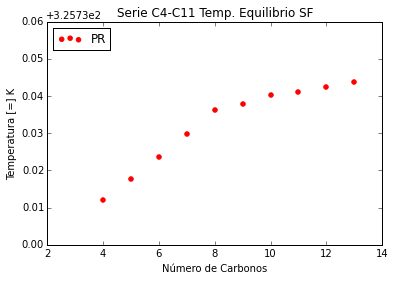

In [117]:
button = widgets.Button(description="Diagrama Serie Sólido-Fluido")

def DiagramaSerieSF(b):
    clear_output()
   
    pyplot.scatter(Ccomp,Tcomp, color = 'red', label = 'PR')
    pyplot.title('Serie C4-C11 Temp. Equilibrio SF')
    pyplot.legend(loc="upper left")      
    pyplot.xlabel('Número de Carbonos')
    pyplot.ylabel('Temperatura [=] K')
    

button.on_click(DiagramaSerieSF)
display(button)